In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns
import pickle
import pandas as pd
import os
import sys
import random

print(tf.keras.__version__)
print(np.__version__)
print(sklearn.__version__)



2.12.0
1.23.5
1.3.0


In [23]:
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)
random.seed(random_state)
os.environ['PYTHONHASHSEED'] = str(random_state)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

In [24]:
module_path = os.path.abspath(os.path.join('..', 'modules'))
if module_path not in sys.path:
    sys.path.append(module_path)
from preprocessing_functions import preprocessing_for_lstm, preprocessing_test

In [25]:
scaled_train_df = pd.read_pickle('../items/scaled_train_df_001.pkl')
scaled_test_df = pd.read_pickle('../items/scaled_test_df_001.pkl')
train_001 = pd.read_pickle('../items/train_001.pkl')
rul_001 = pd.read_pickle('../items/rul_001.pkl')

In [26]:
def asymmetric_loss(RUL_true, RUL_predicted, a1=10, a2=13):

    diff = tf.subtract(RUL_true,RUL_predicted)
    loss = tf.reduce_sum(tf.where(diff < 0, tf.exp(-diff/a1)-1, tf.exp(diff/a2)-1), axis=0)
    return loss

In [27]:
window_size = 30
ceil_rul=float(150)
X, y = preprocessing_for_lstm(scaled_train_df, "engine_num", train_001['rul'], window_size, ["engine_num"],max_rul=ceil_rul, shift = 1)
shuffled_index = np.random.permutation(len(X))
X, y = X[shuffled_index], y[shuffled_index]

In [28]:
test_processed = preprocessing_test(scaled_test_df, "engine_num", ["engine_num"], window_size=window_size)

In [29]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)
print("test_processed shape: ", test_processed.shape)
print("RUL_FD001 shape: ", rul_001.shape)

X shape:  (17731, 30, 15)
y shape:  (17731,)
test_processed shape:  (100, 30, 15)
RUL_FD001 shape:  (100, 1)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = random_state)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (14184, 30, 15)
X_test shape:  (3547, 30, 15)
y_train shape:  (14184,)
y_test shape:  (3547,)


In [31]:
initializer = tf.initializers.GlorotNormal(seed=random_state)

model = Sequential([
    layers.LSTM(128, input_shape = (X.shape[1], X.shape[2]), return_sequences=True, activation = "tanh", bias_initializer="ones", kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4),
               ),        
    layers.LSTM(64, activation = "tanh", bias_initializer="ones", kernel_initializer=initializer,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3),
               ),
    layers.Dropout(0.5, seed=random_state),
    layers.Dense(32, activation = "relu", kernel_initializer=initializer,
                ),
    layers.Dense(8, activation = "relu", kernel_initializer=initializer,
                ),
    layers.Dense(1)
])

model.compile(loss = asymmetric_loss, metrics=["mse"], optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))

In [32]:
history = model.fit(X_train, y_train, epochs = 30,
                    validation_data = (X_test, y_test),
                    shuffle = False,
                    batch_size = 96, verbose = 2)
loss, mse = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MSE: {mse}")

Epoch 1/30
148/148 - 16s - loss: 798965.5625 - mse: 6869.4946 - val_loss: 70219.3516 - val_mse: 4003.4995 - 16s/epoch - 108ms/step
Epoch 2/30
148/148 - 12s - loss: 35519.5156 - mse: 3144.4739 - val_loss: 12110.3916 - val_mse: 2190.5156 - 12s/epoch - 81ms/step
Epoch 3/30
148/148 - 13s - loss: 10034.6377 - mse: 1882.4207 - val_loss: 4477.7847 - val_mse: 1456.3654 - 13s/epoch - 85ms/step
Epoch 4/30
148/148 - 12s - loss: 5018.4375 - mse: 1392.3561 - val_loss: 2414.8530 - val_mse: 1089.3890 - 12s/epoch - 80ms/step
Epoch 5/30
148/148 - 13s - loss: 3188.4802 - mse: 1123.5560 - val_loss: 1613.5267 - val_mse: 872.2809 - 13s/epoch - 87ms/step
Epoch 6/30
148/148 - 19s - loss: 2613.4189 - mse: 992.6611 - val_loss: 1255.3245 - val_mse: 766.6147 - 19s/epoch - 126ms/step
Epoch 7/30
148/148 - 19s - loss: 2031.4170 - mse: 860.2090 - val_loss: 1002.3988 - val_mse: 674.3007 - 19s/epoch - 126ms/step
Epoch 8/30
148/148 - 18s - loss: 1727.9580 - mse: 769.0467 - val_loss: 813.4200 - val_mse: 582.3432 - 18s/e

In [33]:
RUL_predicted = model.predict(test_processed)

MSE = mean_squared_error(rul_001, RUL_predicted)
MAE = np.abs(rul_001 - RUL_predicted).values.mean()
std_AE = np.abs(rul_001 - RUL_predicted).values.std()
R2 = r2_score(rul_001, RUL_predicted)
print("MSE: ", MSE.round(2))
print("RMSE: ", np.sqrt(MSE).round(2))
print("MAE: ", MAE.round(2))
print("R² Score: ", R2.round(2))
print("assymetric_loss: ", asymmetric_loss(rul_001, RUL_predicted).numpy())

4/4 [==============================] - 1s 11ms/step
MSE:  219.5
RMSE:  14.82
MAE:  10.62
R² Score:  0.87
assymetric_loss:  [350.79653367]


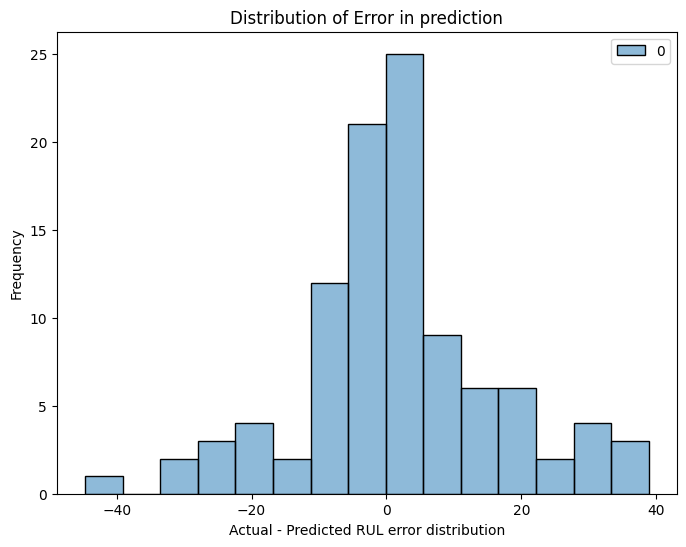

In [34]:
prediction_difference = np.array(rul_001 - RUL_predicted)
plt.figure(figsize=(8, 6))
sns.histplot(prediction_difference, bins=15)
plt.xlabel("Actual - Predicted RUL error distribution")
plt.ylabel("Frequency")
plt.title("Distribution of Error in prediction")
plt.show()

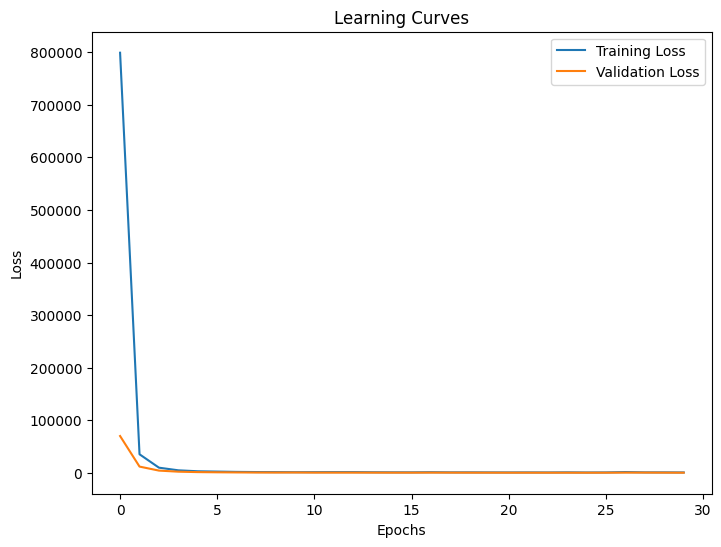

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

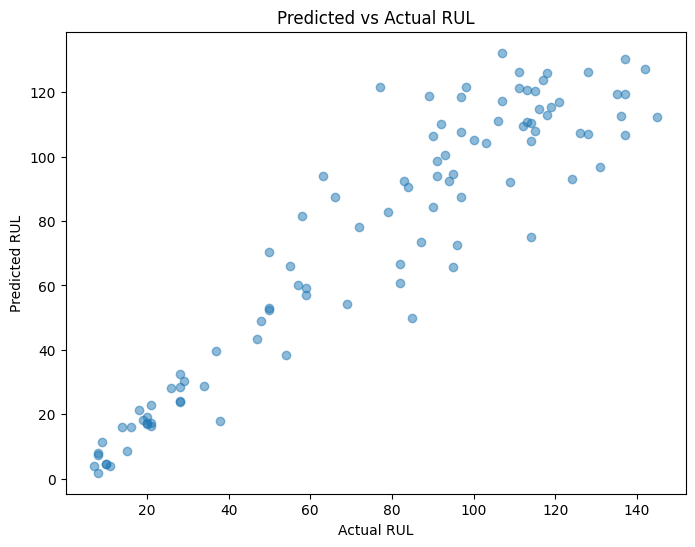

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(rul_001, RUL_predicted, alpha=0.5)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted vs Actual RUL')
plt.show()

In [37]:
model.save('../items/final_model.h5')